In [1]:
import cobra

In [3]:
model = cobra.io.read_sbml_model("/home/joonyoung/Python/iML1515.xml")

In [8]:
cyto_n = 0
all_cyto = 0
for met in model.metabolites:
    if met.compartment == "c":
        all_cyto = all_cyto +1
        if "N" in met.formula:
             cyto_n = cyto_n +1
                
print ("All of cytoplasmic metabolites in iML1515 are ", all_cyto)
print ("Has nitrogen? ", cyto_n)

All of cytoplasmic metabolites in iML1515 are  1071
Has nitrogen?  628


In [ ]:
def has_exch_rxn( met ) :
    cnt_loop = 0
    for rxn in model.reactions :
        cnt_loop = cnt_loop + 1
        tem = []
        for i in rxn.metabolites.keys():
            tem.append(str(i)) 
        if not met in tem:
            continue
        if rxn.id.startswith( "EX_" ) and rxn.get_coefficient( met ) < 0 :
            return str(rxn)        
    return None

#has_exch_rxn( model.metabolites.cytd_e )

model = cobra.io.read_sbml_model("/home/joonyoung/Python/iML1515.xml")

cnt_withn = 0
cnt_n_exch = 0
cnt_growth = 0
growth = []
n_growth = {}
n_ex_rxn = {}
n_solution = {}


for met in model.metabolites:
    if "N" in met.formula:
        cnt_withn = cnt_withn + 1
        #print (met, met.formula)
        ex_rxn_ = has_exch_rxn( str(met) )
        if ex_rxn_ is not None :
            ex_rxn  = ex_rxn_.split(":")[0]
            #print met.id
            cnt_n_exch = cnt_n_exch + 1
            model0 = cobra.io.read_sbml_model("/home/joonyoung/Python/iML1515.xml")
            model0.remove_reactions( model0.reactions.GLCptspp )
            model0.reactions.EX_nh4_e.lower_bound = 0
            model0.reactions.EX_nh4_e.upper_bound = 0
            model0.reactions.get_by_id( ex_rxn ).lower_bound = -10
            model0.optimize()
            
            print (met.id, model0.optimize().objective_value)
            growth.append( model0.optimize().objective_value )
            
            if model0.optimize().objective_value > 0.5 and met.id not in n_growth.keys() :
                n_growth[ str( met.id ) ] = str( model0.optimize().objective_value )
                n_ex_rxn[ str( met.id ) ] = ex_rxn
                n_solution[ str( met.id ) ] = model0.optimize().objective_value

print ("Metabolites with N: " + str( cnt_withn ))
print ("Metabolites with N and exchanage rxn: " + str( cnt_n_exch ))   

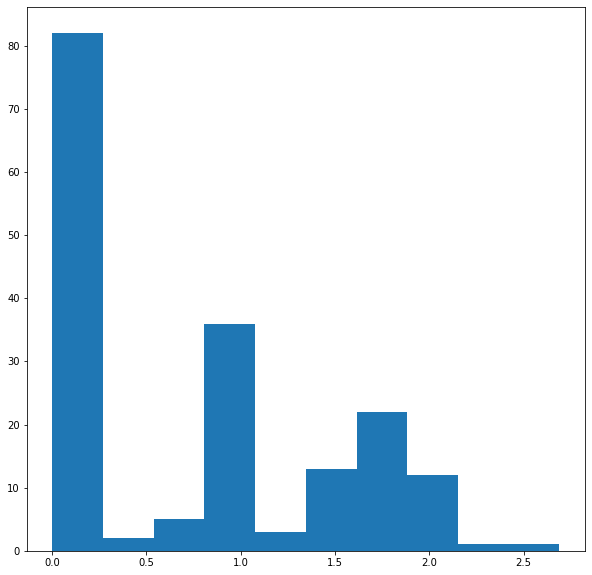

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, ax = plt.subplots( 1, 1, figsize = ( 10, 10 ) )
#plt.axis( [ 6, 9, 0.5, 1.0 ] )
#plt.xlabel( "uptake rate for carbon source" )
#plt.ylabel( "growth rate" )
ax.hist( growth )
#plt.legend( loc = "lower right" )
plt.draw()
plt.savefig( '/home/joonyoung/Python/n_growth_thresh.pdf' ) 
plt.show()


In [30]:
with open("n_source_iML1515.txt", "w") as f:
    for i in sorted(n_ex_rxn):
        f.write(("%s\t%s\n")%(i,"EX_"+i))